<a href="https://colab.research.google.com/github/MooyeongJoo/maxwell1/blob/master/week12_nsmc_lstm_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install konlpy
!pip install koreanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 47.8 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

from konlpy.tag import Okt

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Bidirectional, Conv1D, GlobalMaxPooling1D, Dense, GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score

In [7]:
df = pd.read_csv("https://raw.githubusercontent.com/hongsukyi/Lectures/main/data/naver_movie_train.txt", sep="\t")
df = df.dropna(subset=['document']).drop_duplicates(['document']).reset_index(drop=True)

df['token_len'] = df['document'].apply(lambda x: len(str(x).split()))
sampled_df = df.sort_values(by='token_len', ascending=False).head(3000).reset_index(drop=True)
print(f"샘플링된 데이터 개수: {len(sampled_df)}")

sampled_df['document'] = sampled_df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True)
sampled_df['document'] = sampled_df['document'].str.strip().str.lower()

sampled_df.head()

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

okt = Okt()

def tokenize_and_filter(sentence):
    tokens = okt.morphs(sentence, stem=True)
    return [t for t in tokens if t not in stopwords and len(t) > 1]

token_okt = [tokenize_and_filter(s) for s in sampled_df['document']]

샘플링된 데이터 개수: 3000


In [8]:
df.head()

,id,document,label,token_len
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,5
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1,4
2,10265843,너무재밓었다그래서보는것을추천한다,0,1
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,6
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,11


In [9]:
df.columns

Index(['id', 'document', 'label', 'token_len'], dtype='object')

In [10]:
df2 = pd.DataFrame(token_okt)
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,민좆,파쇼,쌕기,종교,같이,깔다,수준,보솤,ㅋㅋㅋㅋㅋ,미군,...,None,None,None,None,None,None,None,None,None,None
1,황당하다,소재,전개,쓰레기,같다,스토리,수준,초월,정말,어느,...,None,None,None,None,None,None,None,None,None,None
2,남자,아비,라면,김윤진,보다,있다,어미,아들,입장,라면,...,None,None,None,None,None,None,None,None,None,None
3,측정,영화,당신,마음,아직,여리다,에게,상처,주지,당신,...,None,None,None,None,None,None,None,None,None,None
4,정유미,정준영,부부,막둥이,부부,보다,윤한,부부,나오다,바로,...,가다,제일,없다,None,None,None,None,None,None,None


In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(token_okt)
sequences = tokenizer.texts_to_sequences(token_okt)
vocab_size = len(tokenizer.word_index) + 1

In [12]:
print(vocab_size)

11653


In [13]:
# 8. 패딩 길이 결정을 위한 시퀀스 길이 분포 확인
sequence_lengths = [len(s) for s in sequences]
print(f"최대 시퀀스 길이 (Okt() 토큰 기준): {max(sequence_lengths)}")
print(f"평균 시퀀스 길이 (Okt() 토큰 기준): {np.mean(sequence_lengths):.0f}")

최대 시퀀스 길이 (Okt() 토큰 기준): 42
평균 시퀀스 길이 (Okt() 토큰 기준): 31


In [14]:
pad_len = 40
padded_sequences = pad_sequences(sequences, maxlen=pad_len,padding='pre')

print(f"\n패딩된 시퀀스 shape: {padded_sequences.shape}")
print(f"패딩된 시퀀스 예시 (첫 번째 리뷰): {padded_sequences[0]}")


패딩된 시퀀스 shape: (3000, 40)
패딩된 시퀀스 예시 (첫 번째 리뷰): [   0    0    0    0    0    0    0    0    0    0 4076 5996 4077  597
  206  615  106 5997 3142 1703 1704  202  228  598  147 5998  112  241
 1703   67 1705    3 5999 2201 6000  544    4 4076 1054 4078]


In [15]:
padded_sequences.dtype

dtype('int32')

In [72]:
# X는 패딩된 시퀀스 전체를 사용합니다.
X = padded_sequences

# y는 샘플링된 데이터프레임(sampled_df)의 'label' 컬럼을 사용합니다.
# .values를 붙여 Numpy 배열 형태로 만들어주는 것이 좋습니다.
y = sampled_df['label'].values

# to_categorical은 다중 분류에서 사용하는 것이므로 여기서는 삭제합니다.
# y = to_categorical(y, num_classes=vocab_size) # <-- 이 줄을 반드시 삭제하거나 주석 처리하세요!

In [51]:
#sequences = np.array(sequences)
X = padded_sequences[:,:-1]
y = padded_sequences[:,-1]

y = to_categorical(y, num_classes=vocab_size)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [74]:
# 3. 실험 함수 정의
embedding_dim = 64
hidden_units = 64
kernel_size =3

In [54]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    Conv1D(filters=hidden_units, kernel_size=kernel_size, activation='tanh'),
    GlobalMaxPooling1D(),
    Dense(vocab_size, activation='sigmoid')])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32, verbose=0)

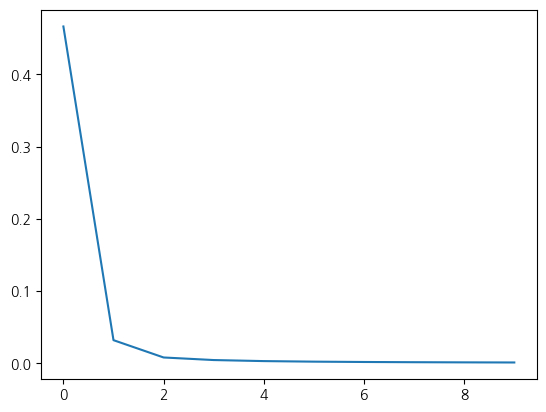

In [ ]:
plt.plot(history.history['loss'])

In [85]:
model_fc.summary()
model_rnn.summary()
model_lstm.summary()
model_gru.summary()
model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)        │ (32, 40, 64)           │       745,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (32, 40, 32)           │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (32, 40, 16)           │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (32, 40, 1)            │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 748,417 (2.85 MB)

 Trainable params: 748,417 (2.85 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ (32, 40, 64)           │       745,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (32, 64)               │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (32, 32)               │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (32, 16)               │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (32, 1)                │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,021 (8.66 MB)

 Trainable params: 756,673 (2.89 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,513,348 (5.77 MB)

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ (32, 40, 64)           │       745,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (32, 64)               │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (32, 32)               │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (32, 16)               │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (32, 1)                │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,344,325 (8.94 MB)

 Trainable params: 781,441 (2.98 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,562,884 (5.96 MB)

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ (32, 40, 64)           │       745,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (32, 64)               │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (32, 32)               │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (32, 16)               │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (32, 1)                │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,320,133 (8.85 MB)

 Trainable params: 773,377 (2.95 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,546,756 (5.90 MB)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (32, 39, 64)           │       745,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (32, 37, 64)           │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (32, 64)               │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (32, 11653)            │       757,445 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,546,769 (17.34 MB)

 Trainable params: 1,515,589 (5.78 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,031,180 (11.56 MB)

In [75]:
model_fc = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    #GlobalAveragePooling1D(),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [76]:
model_rnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    SimpleRNN(hidden_units, activation='tanh'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid') # Output for binary classification
])

In [77]:
model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    LSTM(hidden_units),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid') # Output for binary classification
])

In [78]:
model_gru = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    GRU(hidden_units),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid') # Output for binary classification
])

In [79]:
model_con = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    Conv1D(filters=hidden_units, kernel_size=kernel_size, activation='relu'), # Changed activation for Conv1D
    GlobalMaxPooling1D(),
    Dense(1, activation='sigmoid')]) # Output for binary classification

In [80]:
model_fc.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_fc = model_fc.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32, verbose=0)

ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(32,), output.shape=(32, 40, 1)

In [81]:
model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_rnn = model_rnn.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32, verbose=0)

In [82]:
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_lstm = model_lstm.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32, verbose=0)

In [83]:
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_gru = model_gru.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32, verbose=0)

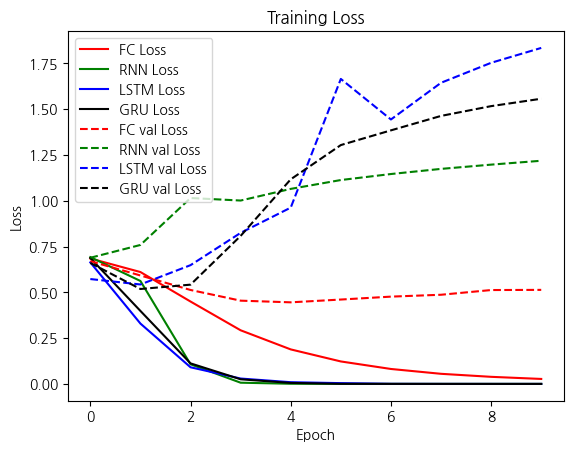

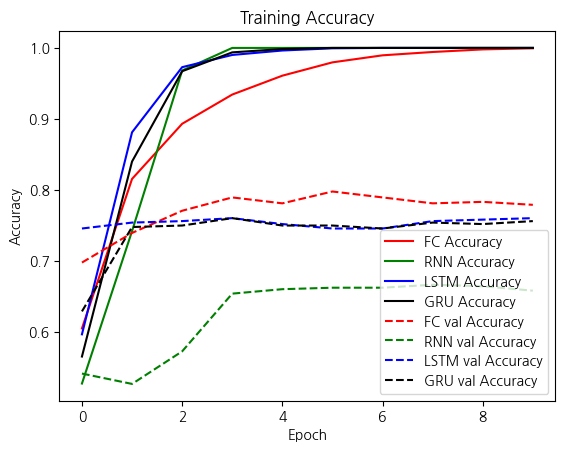

In [84]:
plt.plot(history_fc.history['loss'],'r', label='FC Loss')
plt.plot(history_rnn.history['loss'],'g', label='RNN Loss')
plt.plot(history_lstm.history['loss'], 'b',label='LSTM Loss')
plt.plot(history_gru.history['loss'],'k', label='GRU Loss')

plt.plot(history_fc.history['val_loss'],'r--', label='FC val Loss')
plt.plot(history_rnn.history['val_loss'],'g--', label='RNN val Loss')
plt.plot(history_lstm.history['val_loss'],'b--', label='LSTM val Loss')
plt.plot(history_gru.history['val_loss'],'k--', label='GRU val Loss')
#plt.plot(history_con.history['loss'], label='CNN Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history_fc.history['accuracy'],'r', label='FC Accuracy')
plt.plot(history_rnn.history['accuracy'],'g', label='RNN Accuracy')
plt.plot(history_lstm.history['accuracy'],'b', label='LSTM Accuracy')
plt.plot(history_gru.history['accuracy'],'k', label='GRU Accuracy')

plt.plot(history_fc.history['val_accuracy'],'r--', label='FC val Accuracy')
plt.plot(history_rnn.history['val_accuracy'],'g--', label='RNN val Accuracy')
plt.plot(history_lstm.history['val_accuracy'],'b--', label='LSTM val Accuracy')
plt.plot(history_gru.history['val_accuracy'],'k--', label='GRU val Accuracy')
#plt.plot(history_con.history['accuracy'], label='CNN Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

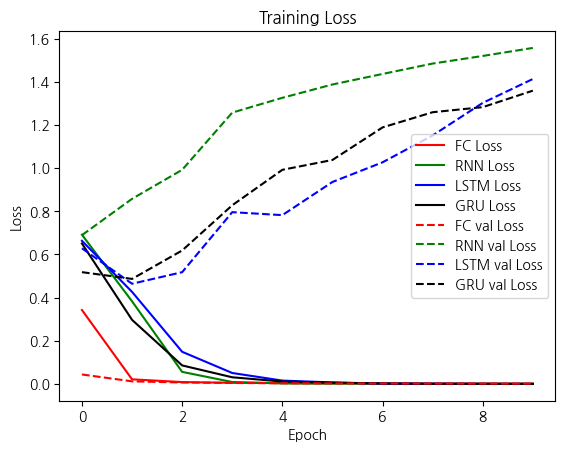

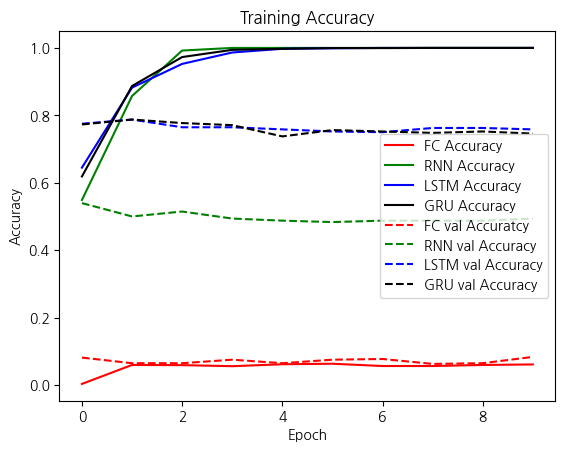

In [56]:
plt.plot(history.history['loss'],'r', label='FC Loss')

#plt.plot(history_fc.history['loss'],'r', label='FC Loss')
plt.plot(history_rnn.history['loss'],'g', label='RNN Loss')
plt.plot(history_lstm.history['loss'], 'b',label='LSTM Loss')
plt.plot(history_gru.history['loss'],'k', label='GRU Loss')


plt.plot(history.history['val_loss'],'r--', label='FC val Loss')
#plt.plot(history_fc.history['val_loss'],'r--', label='FC val Loss')
plt.plot(history_rnn.history['val_loss'],'g--', label='RNN val Loss')
plt.plot(history_lstm.history['val_loss'],'b--', label='LSTM val Loss')
plt.plot(history_gru.history['val_loss'],'k--', label='GRU val Loss')
#plt.plot(history_con.history['loss'], label='CNN Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(history.history['accuracy'],'r', label='FC Accuracy')
#plt.plot(history_fc.history['accuracy'],'r', label='FC Accuracy')
plt.plot(history_rnn.history['accuracy'],'g', label='RNN Accuracy')
plt.plot(history_lstm.history['accuracy'],'b', label='LSTM Accuracy')
plt.plot(history_gru.history['accuracy'],'k', label='GRU Accuracy')


plt.plot(history.history['val_accuracy'],'r--', label='FC val Accuratcy')
#plt.plot(history_fc.history['val_accuracy'],'r--', label='FC val Accuracy')
plt.plot(history_rnn.history['val_accuracy'],'g--', label='RNN val Accuracy')
plt.plot(history_lstm.history['val_accuracy'],'b--', label='LSTM val Accuracy')
plt.plot(history_gru.history['val_accuracy'],'k--', label='GRU val Accuracy')
#plt.plot(history_con.history['accuracy'], label='CNN Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

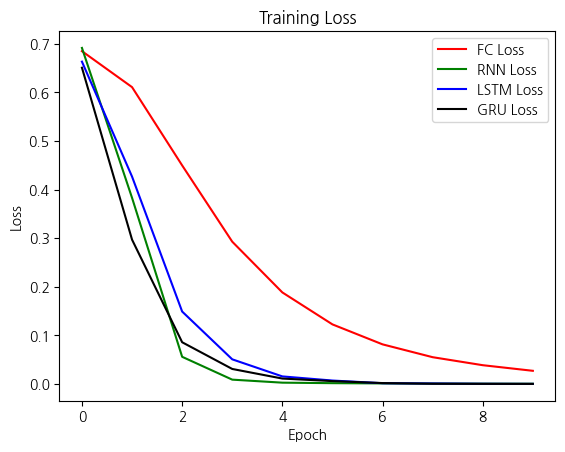

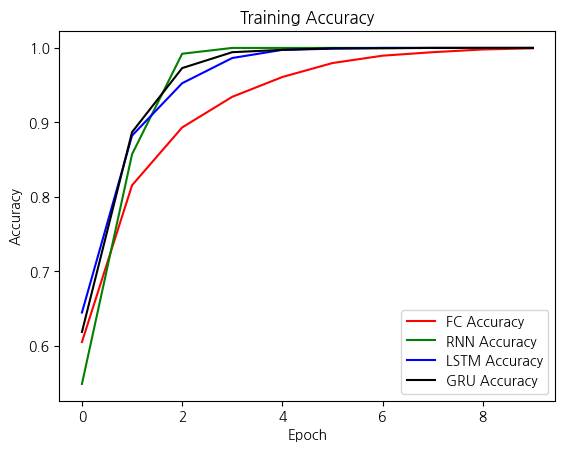

In [50]:
plt.plot(history_fc.history['loss'],'r', label='FC Loss')
plt.plot(history_rnn.history['loss'],'g', label='RNN Loss')
plt.plot(history_lstm.history['loss'], 'b',label='LSTM Loss')
plt.plot(history_gru.history['loss'],'k', label='GRU Loss')


plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history_fc.history['accuracy'],'r', label='FC Accuracy')
plt.plot(history_rnn.history['accuracy'],'g', label='RNN Accuracy')
plt.plot(history_lstm.history['accuracy'],'b', label='LSTM Accuracy')
plt.plot(history_gru.history['accuracy'],'k', label='GRU Accuracy')


plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()